In [7]:
# ============================
# IMPORT LIBRARY
# ============================
import simpy
import random
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
from dataclasses import dataclass, field
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

# Enable Plotly untuk Jupyter
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

print("✅ Semua library berhasil diimpor!")

✅ Semua library berhasil diimpor!


In [8]:
# ============================
# CUSTOM DISPLAY STYLING
# ============================
def apply_custom_style():
    """Terapkan styling untuk output Jupyter"""
    style = """
    <style>
    .output_result {
        background: linear-gradient(135deg, #0f172a 0%, #1e293b 100%);
        border-radius: 12px;
        padding: 15px;
        margin: 10px 0;
        border: 1px solid rgba(99, 102, 241, 0.3);
    }
    .metric-box {
        display: inline-block;
        background: rgba(30, 41, 59, 0.8);
        padding: 12px 20px;
        margin: 5px;
        border-radius: 10px;
        border: 1px solid rgba(99, 102, 241, 0.4);
        min-width: 150px;
        text-align: center;
    }
    .metric-label {
        color: #94a3b8;
        font-size: 12px;
        text-transform: uppercase;
    }
    .metric-value {
        color: #f1f5f9;
        font-size: 20px;
        font-weight: bold;
        margin-top: 5px;
    }
    .success { color: #86efac !important; }
    .warning { color: #fcd34d !important; }
    .info { color: #93c5fd !important; }
    </style>
    """
    display(HTML(style))

apply_custom_style()

In [9]:
# ============================
# KONFIGURASI SIMULASI
# ============================
@dataclass
class Config:
    """Konfigurasi parameter simulasi piket IT Del"""
    
    NUM_MEJA: int = 60
    MAHASISWA_PER_MEJA: int = 3
    
    # Staff allocation (total 7 orang)
    STAFF_LAUK: int = 2
    STAFF_ANGKAT: int = 2
    STAFF_NASI: int = 3
    
    # Waktu layanan dalam menit (akan di-scale berdasarkan target)
    LAUK_MIN: float = 0.17
    LAUK_MAX: float = 0.30
    ANGKAT_MIN: float = 0.17
    ANGKAT_MAX: float = 0.30
    ANGKAT_BATCH_MIN: int = 5
    ANGKAT_BATCH_MAX: int = 8
    NASI_MIN: float = 0.17
    NASI_MAX: float = 0.30
    
    START_HOUR: int = 7
    START_MINUTE: int = 0
    RANDOM_SEED: int = 42
    
    @property
    def TOTAL_OMPRENG(self):
        return self.NUM_MEJA * self.MAHASISWA_PER_MEJA


# ============================
# MODEL SIMULASI
# ============================
class SistemPiketITDel:
    def __init__(self, config: Config):
        self.config = config
        self.env = simpy.Environment()
        
        # Resources
        self.lauk = simpy.Resource(self.env, capacity=config.STAFF_LAUK)
        self.angkat = simpy.Resource(self.env, capacity=config.STAFF_ANGKAT)
        self.nasi = simpy.Resource(self.env, capacity=config.STAFF_NASI)
        
        # Queues & buffers
        self.antrian_lauk = simpy.Store(self.env)
        self.antrian_nasi = simpy.Store(self.env)
        self.buffer_angkat = []
        
        # Statistics collector
        self.statistics = {
            'ompreng_data': [],
            'waktu_tunggu_lauk': [],
            'waktu_tunggu_angkat': [],
            'waktu_tunggu_nasi': [],
            'waktu_layanan_lauk': [],
            'waktu_layanan_angkat': [],
            'waktu_layanan_nasi': [],
            'batch_sizes': [],
            'utilization': {'lauk': [], 'angkat': [], 'nasi': []}
        }
        
        self.start_time = datetime(2024, 1, 1, config.START_HOUR, config.START_MINUTE)
        random.seed(config.RANDOM_SEED)
        np.random.seed(config.RANDOM_SEED)
        
        self.ompreng_diproses = 0
        self.ompreng_total = config.TOTAL_OMPRENG
        self.batch_count = 0
    
    def waktu_ke_jam(self, waktu_simulasi: float) -> datetime:
        """Konversi waktu simulasi (menit) ke datetime"""
        return self.start_time + timedelta(minutes=waktu_simulasi)
    
    def generate_lauk_time(self): 
        return random.uniform(self.config.LAUK_MIN, self.config.LAUK_MAX)
    
    def generate_angkat_time(self): 
        return random.uniform(self.config.ANGKAT_MIN, self.config.ANGKAT_MAX)
    
    def generate_batch_size(self): 
        return random.randint(self.config.ANGKAT_BATCH_MIN, self.config.ANGKAT_BATCH_MAX)
    
    def generate_nasi_time(self): 
        return random.uniform(self.config.NASI_MIN, self.config.NASI_MAX)
    
    def proses_lauk(self, ompreng_id: int):
        """Proses pengisian lauk"""
        waktu_datang = self.env.now
        
        yield self.antrian_lauk.put(ompreng_id)
        
        with self.lauk.request() as request:
            yield request
            yield self.antrian_lauk.get()
            
            self.statistics['utilization']['lauk'].append({
                'time': self.env.now,
                'in_use': self.lauk.count
            })
            
            lauk_time = self.generate_lauk_time()
            yield self.env.timeout(lauk_time)
            
            self.statistics['waktu_layanan_lauk'].append(lauk_time)
            self.statistics['waktu_tunggu_lauk'].append(
                self.env.now - waktu_datang - lauk_time
            )
        
        # Masuk buffer angkat
        self.buffer_angkat.append({
            'id': ompreng_id,
            'waktu_masuk': self.env.now
        })
    
    def proses_angkat(self):
        """Proses pengangkatan batch ompreng"""
        while self.ompreng_diproses < self.ompreng_total:
            batch_target = self.generate_batch_size()
            
            # Tunggu hingga batch tersedia
            while (len(self.buffer_angkat) < batch_target and 
                   len(self.buffer_angkat) + self.ompreng_diproses < self.ompreng_total):
                yield self.env.timeout(0.1)
            
            if self.buffer_angkat:
                batch_size = min(batch_target, len(self.buffer_angkat))
                
                # Skip batch terlalu kecil jika masih ada ompreng belum diproses
                if batch_size < 4 and (self.ompreng_diproses + len(self.buffer_angkat) < self.ompreng_total):
                    continue
                
                # Ambil batch
                batch = self.buffer_angkat[:batch_size]
                self.buffer_angkat = self.buffer_angkat[batch_size:]
                
                self.batch_count += 1
                self.statistics['batch_sizes'].append(batch_size)
                
                # Catat waktu tunggu angkat
                for item in batch:
                    self.statistics['waktu_tunggu_angkat'].append(
                        self.env.now - item['waktu_masuk']
                    )
                
                # Proses angkat
                with self.angkat.request() as request:
                    yield request
                    self.statistics['utilization']['angkat'].append({
                        'time': self.env.now, 
                        'in_use': self.angkat.count
                    })
                    
                    angkat_time = self.generate_angkat_time()
                    yield self.env.timeout(angkat_time)
                    self.statistics['waktu_layanan_angkat'].append(angkat_time)
                
                # Lanjut ke proses nasi
                for item in batch:
                    yield self.antrian_nasi.put(item['id'])
                    self.env.process(self.proses_nasi(item['id']))
            else:
                yield self.env.timeout(0.1)
    
    def proses_nasi(self, ompreng_id: int):
        """Proses pengisian nasi"""
        waktu_masuk = self.env.now
        
        with self.nasi.request() as request:
            yield request
            self.statistics['utilization']['nasi'].append({
                'time': self.env.now, 
                'in_use': self.nasi.count
            })
            
            nasi_time = self.generate_nasi_time()
            yield self.env.timeout(nasi_time)
            
            self.statistics['waktu_layanan_nasi'].append(nasi_time)
            self.statistics['waktu_tunggu_nasi'].append(
                self.env.now - waktu_masuk - nasi_time
            )
            
            # Simpan data selesai
            self.statistics['ompreng_data'].append({
                'id': ompreng_id,
                'waktu_selesai': self.env.now,
                'jam_selesai': self.waktu_ke_jam(self.env.now)
            })
            
            self.ompreng_diproses += 1
    
    def run_simulation(self):
        """Jalankan simulasi lengkap"""
        # Reset state
        self.ompreng_diproses = 0
        self.buffer_angkat = []
        self.batch_count = 0
        for key in self.statistics:
            if isinstance(self.statistics[key], list):
                self.statistics[key].clear()
            elif isinstance(self.statistics[key], dict):
                for k in self.statistics[key]:
                    if isinstance(self.statistics[key][k], list):
                        self.statistics[key][k].clear()
        
        # Start processes
        self.env.process(self.proses_angkat())
        
        for i in range(self.ompreng_total):
            self.env.process(self.proses_lauk(i))
        
        # Run simulation
        self.env.run()
        
        return self.analyze_results()
    
    def analyze_results(self):
        """Analisis hasil simulasi"""
        if not self.statistics['ompreng_data']:
            return None, None
        
        df = pd.DataFrame(self.statistics['ompreng_data'])
        
        results = {
            'total_ompreng': len(df),
            'waktu_selesai_terakhir': df['waktu_selesai'].max(),
            'jam_selesai_terakhir': self.waktu_ke_jam(df['waktu_selesai'].max()),
            'avg_waktu_tunggu_lauk': (
                np.mean(self.statistics['waktu_tunggu_lauk']) * 60 
                if self.statistics['waktu_tunggu_lauk'] else 0
            ),
            'avg_waktu_tunggu_angkat': (
                np.mean(self.statistics['waktu_tunggu_angkat']) * 60 
                if self.statistics['waktu_tunggu_angkat'] else 0
            ),
            'avg_waktu_tunggu_nasi': (
                np.mean(self.statistics['waktu_tunggu_nasi']) * 60 
                if self.statistics['waktu_tunggu_nasi'] else 0
            ),
            'avg_waktu_layanan_lauk': np.mean(self.statistics['waktu_layanan_lauk']) * 60,
            'avg_waktu_layanan_angkat': np.mean(self.statistics['waktu_layanan_angkat']) * 60,
            'avg_waktu_layanan_nasi': np.mean(self.statistics['waktu_layanan_nasi']) * 60,
            'avg_batch_size': (
                np.mean(self.statistics['batch_sizes']) 
                if self.statistics['batch_sizes'] else 0
            ),
            'total_batch': len(self.statistics['batch_sizes']),
            'utilisasi_lauk': 0,
            'utilisasi_angkat': 0,
            'utilisasi_nasi': 0
        }
        
        # Hitung utilisasi
        total_time = results['waktu_selesai_terakhir']
        if total_time > 0:
            total_lauk = sum(self.statistics['waktu_layanan_lauk'])
            results['utilisasi_lauk'] = (
                total_lauk / (total_time * self.config.STAFF_LAUK)
            ) * 100
            
            total_angkat = sum(self.statistics['waktu_layanan_angkat'])
            results['utilisasi_angkat'] = (
                total_angkat / (total_time * self.config.STAFF_ANGKAT)
            ) * 100
            
            total_nasi = sum(self.statistics['waktu_layanan_nasi'])
            results['utilisasi_nasi'] = (
                total_nasi / (total_time * self.config.STAFF_NASI)
            ) * 100
        
        return results, df

In [10]:
# ============================
# FUNGSI VISUALISASI
# ============================

def create_timeline_chart(df):
    """Timeline penyelesaian per jam"""
    if df is None or df.empty:
        return None
    
    df_copy = df.copy()
    df_copy['jam'] = df_copy['jam_selesai'].dt.hour
    df_copy['menit'] = df_copy['jam_selesai'].dt.minute
    df_copy['waktu_label'] = (
        df_copy['jam'].astype(str) + ':' + 
        df_copy['menit'].astype(str).str.zfill(2)
    )
    
    hourly = df_copy['waktu_label'].value_counts().sort_index()
    
    fig = px.bar(
        x=hourly.index,
        y=hourly.values,
        title='🕐 Distribusi Penyelesaian per Waktu',
        labels={'x': 'Waktu', 'y': 'Jumlah Ompreng Selesai'},
        color=hourly.values,
        color_continuous_scale='Viridis'
    )
    fig.update_layout(
        xaxis_title="Jam",
        yaxis_title="Jumlah Ompreng",
        coloraxis_showscale=False,
        plot_bgcolor='rgba(0,0,0,0)',
        paper_bgcolor='rgba(0,0,0,0)',
        font=dict(color='#cbd5e1'),
        height=400
    )
    return fig


def create_batch_size_chart(batch_sizes):
    """Histogram distribusi ukuran batch"""
    if not batch_sizes:
        return None
    
    fig = px.histogram(
        x=batch_sizes,
        nbins=10,
        title='📦 Distribusi Ukuran Batch Pengangkatan',
        labels={'x': 'Ukuran Batch (ompreng)', 'y': 'Frekuensi'},
        color_discrete_sequence=['#fbbf24']
    )
    fig.update_layout(
        hovermode='x unified',
        plot_bgcolor='rgba(0,0,0,0)',
        paper_bgcolor='rgba(0,0,0,0)',
        font=dict(color='#cbd5e1'),
        height=400
    )
    return fig


def create_utilization_gauge(label, value, color):
    """Gauge chart utilisasi staff"""
    fig = go.Figure(go.Indicator(
        mode="gauge+number",
        value=value,
        title={'text': label, 'font': {'size': 14}},
        gauge={
            'axis': {'range': [0, 100], 'tickcolor': '#64748b'},
            'bar': {'color': color},
            'steps': [
                {'range': [0, 50], 'color': "rgba(100,116,139,0.2)"},
                {'range': [50, 80], 'color': "rgba(100,116,139,0.4)"},
                {'range': [80, 100], 'color': "rgba(100,116,139,0.6)"}
            ],
            'threshold': {
                'line': {'color': "#f87171", 'width': 4},
                'thickness': 0.75,
                'value': 90
            }
        }
    ))
    fig.update_layout(
        height=220, 
        margin=dict(l=20, r=20, t=40, b=20),
        paper_bgcolor='rgba(0,0,0,0)',
        font=dict(color='#f1f5f9')
    )
    return fig


def create_wait_time_chart(statistics):
    """Histogram waktu tunggu per tahap"""
    fig = go.Figure()
    
    if statistics['waktu_tunggu_lauk']:
        fig.add_trace(go.Histogram(
            x=np.array(statistics['waktu_tunggu_lauk']) * 60,
            name='Lauk',
            opacity=0.7,
            marker_color='#3b82f6',
            nbinsx=20
        ))
    
    if statistics['waktu_tunggu_angkat']:
        fig.add_trace(go.Histogram(
            x=np.array(statistics['waktu_tunggu_angkat']) * 60,
            name='Angkat',
            opacity=0.7,
            marker_color='#f97316',
            nbinsx=20
        ))
    
    if statistics['waktu_tunggu_nasi']:
        fig.add_trace(go.Histogram(
            x=np.array(statistics['waktu_tunggu_nasi']) * 60,
            name='Nasi',
            opacity=0.7,
            marker_color='#22c55e',
            nbinsx=20
        ))
    
    fig.update_layout(
        title='📊 Distribusi Waktu Tunggu per Tahap (detik)',
        xaxis_title='Waktu Tunggu (detik)',
        yaxis_title='Frekuensi',
        barmode='overlay',
        hovermode='x unified',
        plot_bgcolor='rgba(0,0,0,0)',
        paper_bgcolor='rgba(0,0,0,0)',
        font=dict(color='#cbd5e1'),
        height=400
    )
    return fig


def display_metrics(results, target_time):
    """Tampilkan metrics utama dengan styling"""
    durasi = results['waktu_selesai_terakhir']
    
    html = f"""
    <div class="output_result">
        <h4 style="color:#f1f5f9;margin:0 0 15px 0;">📊 Hasil Simulasi</h4>
        <div style="display:flex;flex-wrap:wrap;gap:10px;">
            <div class="metric-box">
                <div class="metric-label">⏱️ Selesai</div>
                <div class="metric-value">{results['jam_selesai_terakhir'].strftime('%H:%M')}</div>
            </div>
            <div class="metric-box">
                <div class="metric-label">⏰ Durasi</div>
                <div class="metric-value">{durasi:.1f} menit</div>
            </div>
            <div class="metric-box">
                <div class="metric-label">📦 Total Batch</div>
                <div class="metric-value">{results['total_batch']}</div>
            </div>
            <div class="metric-box">
                <div class="metric-label">📊 Avg Batch</div>
                <div class="metric-value">{results['avg_batch_size']:.1f}</div>
            </div>
        </div>
    """
    
    # Status evaluasi
    if abs(durasi - target_time) < 2:
        status = '<span class="success">✅ Mendekati target!</span>'
    elif durasi < target_time:
        status = f'<span class="warning">⚠️ Terlalu cepat ({durasi:.1f} vs {target_time} menit)</span>'
    else:
        status = f'<span class="warning">⚠️ Terlalu lambat ({durasi:.1f} vs {target_time} menit)</span>'
    
    html += f'<div style="margin-top:15px;padding:10px;background:rgba(30,41,59,0.6);border-radius:8px;">{status}</div></div>'
    display(HTML(html))


def display_details(results, config):
    """Tampilkan detail hasil dalam format rapi"""
    html = """
    <div class="output_result" style="margin-top:15px;">
        <h4 style="color:#f1f5f9;margin:0 0 15px 0;">📋 Detail Hasil</h4>
        <div style="display:grid;grid-template-columns:1fr 1fr;gap:20px;">
            <div>
                <strong style="color:#94a3b8;">Waktu Tunggu Rata-rata (detik)</strong><br>
                • Lauk: <span class="info">{lauk_tunggu:.1f}</span><br>
                • Angkat: <span class="info">{angkat_tunggu:.1f}</span><br>
                • Nasi: <span class="info">{nasi_tunggu:.1f}</span><br><br>
                <strong style="color:#94a3b8;">Waktu Layanan Rata-rata (detik)</strong><br>
                • Lauk: <span class="success">{lauk_layanan:.1f}</span><br>
                • Angkat: <span class="success">{angkat_layanan:.1f}</span><br>
                • Nasi: <span class="success">{nasi_layanan:.1f}</span>
            </div>
            <div>
                <strong style="color:#94a3b8;">Utilisasi Staff (%)</strong><br>
                • Lauk ({config_lauk}): <span class="warning">{util_lauk:.1f}%</span><br>
                • Angkat ({config_angkat}): <span class="warning">{util_angkat:.1f}%</span><br>
                • Nasi ({config_nasi}): <span class="warning">{util_nasi:.1f}%</span><br><br>
                <strong style="color:#94a3b8;">Parameter</strong><br>
                • Batch size: {batch_min}-{batch_max}<br>
                • Total ompreng: 180
            </div>
        </div>
    </div>
    """.format(
        lauk_tunggu=results['avg_waktu_tunggu_lauk'],
        angkat_tunggu=results['avg_waktu_tunggu_angkat'],
        nasi_tunggu=results['avg_waktu_tunggu_nasi'],
        lauk_layanan=results['avg_waktu_layanan_lauk'],
        angkat_layanan=results['avg_waktu_layanan_angkat'],
        nasi_layanan=results['avg_waktu_layanan_nasi'],
        config_lauk=config.STAFF_LAUK,
        config_angkat=config.STAFF_ANGKAT,
        config_nasi=config.STAFF_NASI,
        util_lauk=results['utilisasi_lauk'],
        util_angkat=results['utilisasi_angkat'],
        util_nasi=results['utilisasi_nasi'],
        batch_min=config.ANGKAT_BATCH_MIN,
        batch_max=config.ANGKAT_BATCH_MAX
    )
    display(HTML(html))

In [11]:
# ============================
# FUNGSI UTAMA SIMULASI
# ============================

def run_piket_simulation(
    target_waktu='20 menit',
    staff_lauk=2,
    staff_angkat=2,
    staff_nasi=3,
    random_seed=42
):
    """
    Jalankan simulasi piket IT Del
    
    Parameters:
    -----------
    target_waktu : str
        Target waktu: '15 menit', '20 menit', ..., '40 menit'
    staff_lauk, staff_angkat, staff_nasi : int
        Jumlah staff per tahap (total disarankan 7)
    random_seed : int
        Seed untuk reproducibility
    """
    
    # Mapping target waktu ke faktor scaling
    waktu_options = {
        '15 menit': 0.7,
        '20 menit': 1.0,
        '25 menit': 1.3,
        '30 menit': 1.6,
        '35 menit': 1.9,
        '40 menit': 2.2
    }
    
    if target_waktu not in waktu_options:
        print(f"❌ Target waktu harus salah satu dari: {list(waktu_options.keys())}")
        return None, None, None
    
    faktor = waktu_options[target_waktu]
    target_time = int(target_waktu.split()[0])
    
    # Hitung parameter waktu layanan
    base_time = 0.17  # 10 detik base
    
    config = Config(
        STAFF_LAUK=staff_lauk,
        STAFF_ANGKAT=staff_angkat,
        STAFF_NASI=staff_nasi,
        LAUK_MIN=base_time * faktor,
        LAUK_MAX=base_time * 1.8 * faktor,
        ANGKAT_MIN=base_time * faktor,
        ANGKAT_MAX=base_time * 1.8 * faktor,
        NASI_MIN=base_time * faktor,
        NASI_MAX=base_time * 1.8 * faktor,
        RANDOM_SEED=random_seed
    )
    
    print(f"🔄 Menjalankan simulasi (target: {target_waktu})...")
    print(f"   Staff: Lauk={staff_lauk}, Angkat={staff_angkat}, Nasi={staff_nasi}")
    print(f"   Total Ompreng: {config.TOTAL_OMPRENG}")
    
    # Run simulation
    model = SistemPiketITDel(config)
    results, df = model.run_simulation()
    
    if results is None or df is None or df.empty:
        print("❌ Simulasi gagal!")
        return None, None, None
    
    print(f"✅ Simulasi selesai! {len(df)} ompreng terproses\n")
    
    # Display results
    display_metrics(results, target_time)
    display_details(results, config)
    
    return results, df, model

In [12]:
# ============================
# FUNGSI PLOT LENGKAP
# ============================

def plot_all_charts(results, df, model):
    """
    Generate dan tampilkan semua visualisasi
    
    Parameters:
    -----------
    results : dict
        Hasil analisis simulasi
    df : DataFrame
        Data hasil simulasi
    model : SistemPiketITDel
        Instance model untuk akses statistics
    """
    if results is None or df is None:
        print("❌ Data tidak valid untuk visualisasi")
        return
    
    config = model.config
    
    print("\n📊 Generating visualizations...")
    
    # 1. Gauge Utilisasi
    print("   • Membuat gauge utilisasi...")
    fig_lauk = create_utilization_gauge(
        f"Lauk ({config.STAFF_LAUK} staff)", 
        results['utilisasi_lauk'], 
        '#3b82f6'
    )
    fig_angkat = create_utilization_gauge(
        f"Angkat ({config.STAFF_ANGKAT} staff)", 
        results['utilisasi_angkat'], 
        '#f97316'
    )
    fig_nasi = create_utilization_gauge(
        f"Nasi ({config.STAFF_NASI} staff)", 
        results['utilisasi_nasi'], 
        '#22c55e'
    )
    
    display(HTML("<h4 style='color:#f1f5f9;'>📈 Utilisasi Staff</h4>"))
    display(fig_lauk)
    display(fig_angkat)
    display(fig_nasi)
    
    # 2. Wait Time Distribution
    print("   • Membuat chart waktu tunggu...")
    fig_wait = create_wait_time_chart(model.statistics)
    if fig_wait:
        display(HTML("<h4 style='color:#f1f5f9;margin-top:20px;'>⏱️ Distribusi Waktu Tunggu</h4>"))
        display(fig_wait)
    
    # 3. Batch Size Distribution
    print("   • Membuat chart ukuran batch...")
    fig_batch = create_batch_size_chart(model.statistics['batch_sizes'])
    if fig_batch:
        display(HTML("<h4 style='color:#f1f5f9;margin-top:20px;'>📦 Distribusi Ukuran Batch</h4>"))
        display(fig_batch)
    
    # 4. Timeline
    print("   • Membuat timeline penyelesaian...")
    fig_timeline = create_timeline_chart(df)
    if fig_timeline:
        display(HTML("<h4 style='color:#f1f5f9;margin-top:20px;'>🕐 Timeline Penyelesaian</h4>"))
        display(fig_timeline)
    
    print("\n✅ Semua visualisasi selesai!")

🔄 Menjalankan simulasi (target: 20 menit)...
   Staff: Lauk=2, Angkat=2, Nasi=3
   Total Ompreng: 180
✅ Simulasi selesai! 180 ompreng terproses




📊 Generating visualizations...
   • Membuat gauge utilisasi...


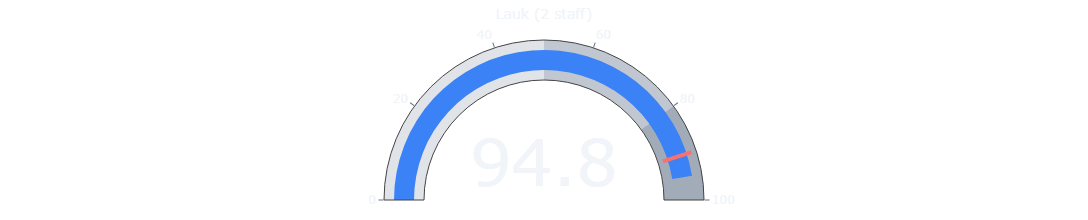

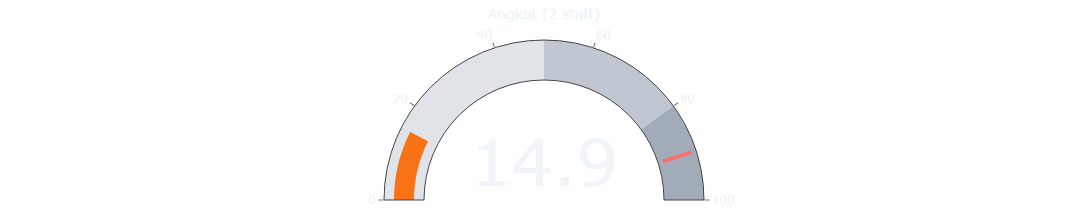

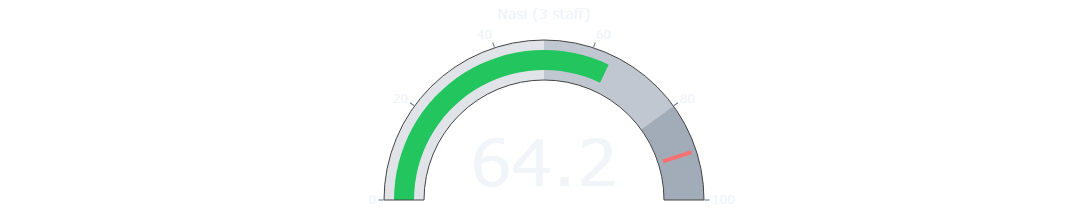

   • Membuat chart waktu tunggu...


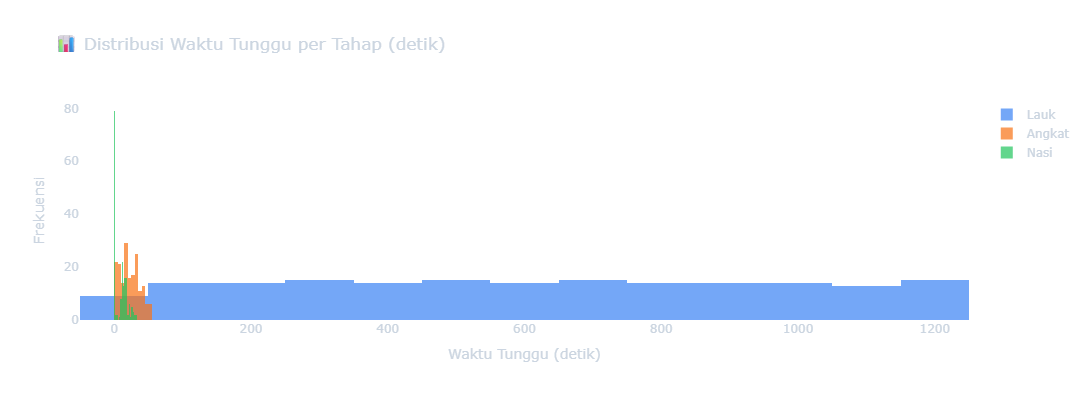

   • Membuat chart ukuran batch...


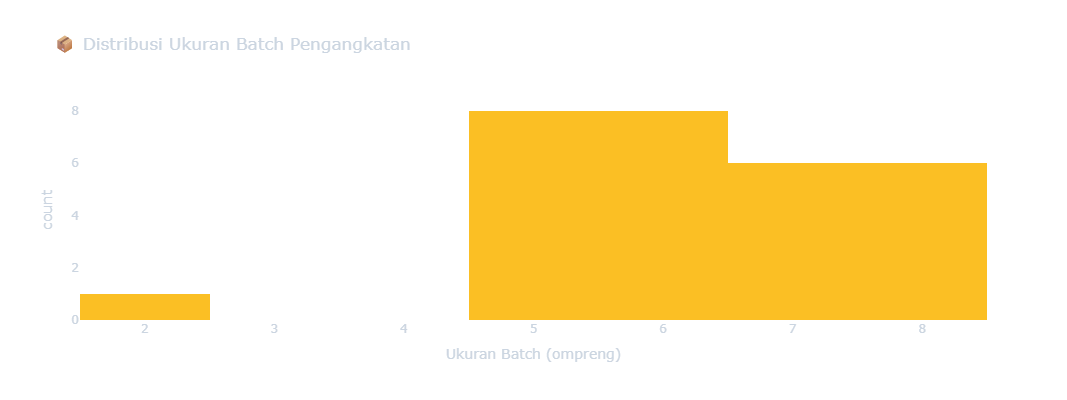

   • Membuat timeline penyelesaian...


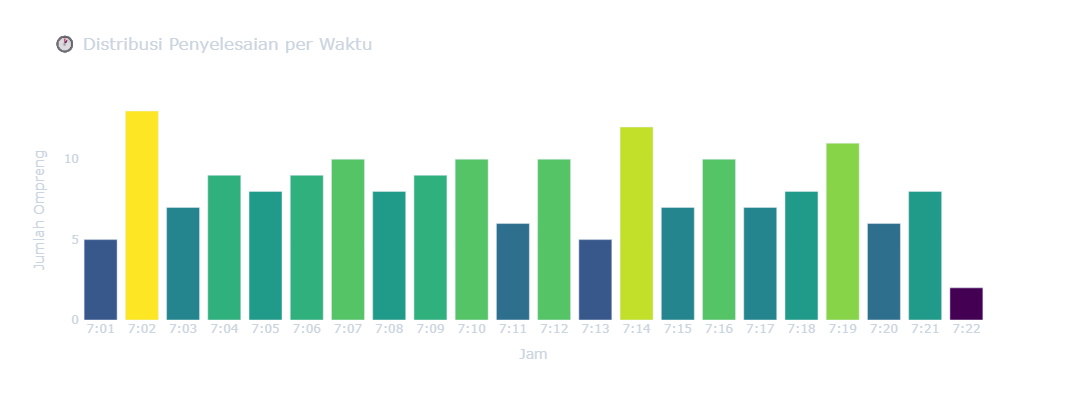


✅ Semua visualisasi selesai!


In [13]:
# ============================
# 🚀 CONTOH PENGGUNAAN
# ============================

# Jalankan simulasi dengan target 20 menit (default)
results, df, model = run_piket_simulation(
    target_waktu='20 menit',
    staff_lauk=2,
    staff_angkat=2,
    staff_nasi=3,
    random_seed=42
)

# Jika simulasi berhasil, tampilkan visualisasi
if results and df is not None and model:
    plot_all_charts(results, df, model)
    
    # Opsional: Simpan data ke CSV
    # df.to_csv('hasil_simulasi_piket.csv', index=False)
    # print(f"\n💾 Data disimpan ke 'hasil_simulasi_piket.csv'")